#Spiker Tools 

Imports for needed libraries

In [2]:
import numpy as np
from scipy import signal  
import math
from scipy.io import wavfile
import matplotlib.pyplot as plt
from datetime import datetime
import random
# imports

Channel Class 

In [4]:
class Channel:
    def __init__(self, data = None, fs= None, filterfreqs= None, label= None, color= None):
        self._data = data if data is not None else [] #data extracted from WAV file, default is empty list
        self._fs = fs if fs is not None else 0 #sampling frequency extracted from WAV file, default is 10,000 Hz
        self._filterfreqs = filterfreqs if filterfreqs is not None else [0,10000] # bandpass filter cutoff frequencies, set by user, default is 0 to 10000 Hz
        self._label = label if label is not None else "channel" #channel string label set by user, default is channel 
        self._color = color if color is not None else 'k' #set by user
        self._t = np.arange(0, (len(self._data)/self._fs), (1/self._fs)) #time vector, elaborated from sample rate and duration of data

        print("Channel created.")

    #getter functions for channel attributes
    def get_data(self):
        return self._data
    def get_fs(self):
        return self._fs
    def get_time(self):
        return self._t 
    def get_filterfreqs(self):
        return self._filterfreqs
    def get_label(self):
        return self._label
    def get_color(self):
        return self._color 
    #setter functions for channel attributes
    def set_data(self, data_in):
        self._data = data_in
        return self._data
    def set_fs(self, fs_in):
        self._fs = fs_in 
        self._t = np.arange(0, (len(self._data)/self._fs), (1/self._fs))
        return self._fs 
    def set_filterfreqs(self, filterfreqs_in):
        self._filterfreqs = filterfreqs_in
        return self._filterfreqs
    def set_label (self, label_in):
        self._label = label_in
        return self._label
    def set_color (self, color_in):
        self._color = color_in
        return self._color 
    #delete functions for channel attributes
    def del_data(self):
        del self._data
    def del_fs(self):
        del self._fs
    def del_time(self):
        del self._t 
    def del_filterfreqs(self):
        del self._filterfreqs
    def del_label(self):
        del self._label
    def del_color(self):
        del self._color 
    
    #tool functions for channel objects

    #filtering function (lowpass, highpass, notch, bandpass, band reject)
    #modifies self._data and self._filterfreqs
    def filt(self, cutoff, ftype, filter_order = 2):
        if (cutoff > ((self._fs)/2)):
            raise Exception(f"Filter frequency should not exceed Nyquist: {(self._fs)/2} ")
        if (ftype == 'hp'): #highpass filter
            assert (isinstance(cutoff, float) or isinstance(cutoff,int)), "Must specify integer or float."
            b_hpf, a_hpf = signal.butter(filter_order, cutoff, 'highpass', fs=self._fs)
            out = signal.filtfilt(b_hpf, a_hpf, self._data)
            self._filterfreqs[0] = cutoff
            self._data = out
        elif (ftype == 'lp'):#lowpass fitler
            assert (isinstance(cutoff, float) or isinstance(cutoff,int)), "Must specify integer or float."
            b_lpf, a_lpf = signal.butter(filter_order, cutoff, 'lowpass', fs=self._fs)
            out = signal.filtfilt(b_lpf, a_lpf, self._data)
            self._filterfreqs[1]= cutoff
            self._data = out
        elif (ftype == 'n'): #notch filter
            assert (isinstance(cutoff, float) or isinstance(cutoff,int)), "Must specify integer or float."
            Q = (math.sqrt((cutoff+1)*(cutoff-1)))/2
            b_notch, a_notch = signal.iirnotch(cutoff, Q ,self._fs)
            out = signal.filtfilt(b_notch, a_notch, self._data)
            self._data = out
        elif (ftype == 'bp'): #bandpass filter
            assert (isinstance(cutoff, list), "Must specify 2-element list") 
            b_bpf, a_bpf = signal.butter(filter_order, cutoff, 'bandpass', fs=self._fs)
            out = signal.filtfilt(b_bpf, a_bpf, self._data)
            self._filterfreqs = cutoff
            self._data = out
        elif (ftype == 'br'): #band reject filter
            assert (isinstance(cutoff, list), "Must specify 2-element list")
            b_brf, a_brf = signal.butter(filter_order, cutoff, 'bandstop', fs = self._fs)
            out = signal.filtfilt(b_brf, a_brf, self._data)
            self._data = out
        else: 
            raise Exception("Incorrect filter type specified!")
        return self

    def get_std(self, interval=[0,0]):
        if (interval == [0,0]):
            return np.std(self._data)
        else: 
            spec_interval = self._data[(interval[0]*self._fs), (interval[1]*self._fs)]
            return np.std(spec_interval)
    
    
    #downsampling function, applies an anti-aliasing filter first, then downsamples
    #modifies self._fs, self._data, and if anti-aliasing filter is less than lowpass filter, self._filterfreq, and the time vector
    def decim(self, decim_factor):
        out_data = signal.decimate(self._data, decim_factor)
        self._data = out_data
        new_fs = self._fs/decim_factor
        self._fs = new_fs
        if (self._filterfreqs[1] > (new_fs)/2):
            self._filterfreqs[1]=new_fs/2 
        self._t = np.arange(0, (len(self._data)/self._fs), (1/self._fs))
        return self

    def normalize(self, norm_type, norm_value = None):
        if (norm_type == 'mean'):
            avg = np.mean(self._data)
            out_data = self._data - avg
            self._data = out_data 
        elif (norm_type == "std"):
            std_coeff = 1/(self.get_std())
            out_data = np.multiply(self._data, std_coeff)
            self._data = out_data 
        elif (norm_type == "scalar"):
            assert((isinstance(norm_value, float) or isinstance(norm_value, int)), "Must specify number for scalar")
            #print(type(norm_value))
            out_data = np.multiply(self._data, norm_value)
            self._data = out_data
        else: 
            raise Exception("Incorrect normalization type specified")
        return self

<>:82: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:88: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:126: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:82: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:88: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:126: SyntaxWarning: assertion is always true, perhaps remove parentheses?
C:\Users\USER\AppData\Local\Temp/ipykernel_15300/2581459598.py:82: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (isinstance(cutoff, list), "Must specify 2-element list")
C:\Users\USER\AppData\Local\Temp/ipykernel_15300/2581459598.py:88: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (isinstance(cutoff, list), "Must specify 2-element list")
C:\Users\USER\AppData\Local\Temp/ipykernel_15300/2581459598.py:126: SyntaxWarning: assertion is always true, perhaps remove parentheses?

Channel created.


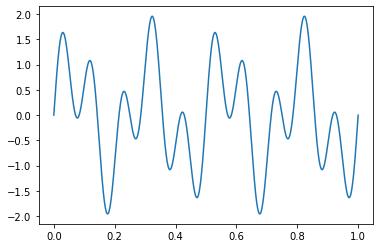

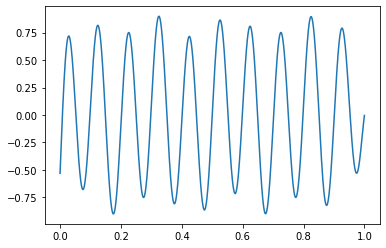

In [ ]:
fs = 44100       # sampling rate, Hz, must be integer
duration = 1   # in seconds, may be float
f1 = 10        # sine frequency, Hz, may be float
f2 = 4       
# generate samples, note conversion to float32 array
data = (np.sin(2*np.pi*np.arange(fs*duration)*(f1)/fs)) + (np.sin(2*np.pi*np.arange(fs*duration)*(f2)/fs))

chan1 = Channel(data, fs)
plt.plot(chan1._t, data)
chan1.filt(7, 'hp', 2)
plt.figure()
plt.plot(chan1._t, chan1.get_data())

Session Class

In [5]:
class Session: 

    def __init__(self, datapath = "", eventspath = ""):
        if (datapath != ""):
            self._datapath = datapath
            if (eventspath == "y"):
                self._eventspath = datapath[:-4] + '-events.txt' 
            elif (eventspath != ""):
                self._eventspath = eventspath
            else:
                self._eventspath = None
                print("No event file specified")
        else:
            self._datapath = None
            self._eventspath = None 
            print("Empty Session object created")
        
        #reading data from file
        if (self._datapath != None):
            try:
                sample_rate, data = wavfile.read(self._datapath)
                self._samplerate = sample_rate
                self._channeldata = data
                self._nchannels = np.ndim(data)
                print(self._nchannels)
                self._channels = []
                if (self._nchannels == 1):
                    add_channel = Channel(data = self._channeldata, fs= self._samplerate)
                    self._channels.append(add_channel)
                else: 
                    self._channeldata = np.transpose(self._channeldata)
                    for i in range(self._nchannels): 
                        add_channel = Channel(data = self._channeldata[i], fs= self._samplerate)
                        self._channels.append(add_channel) 
            except: 
               print("Incorrect filename specified.")
        if (self._eventspath != None):
            with open(self._eventspath) as event_file:
                timestamps = event_file.readlines()
                timestamps = timestamps[2:]
                events = {}
                for timestamp in timestamps:
                    event = timestamp[0]
                    if event not in events:
                        events[event] = [float(timestamp.split(',')[1])]
                    elif event in events:
                        temp = events[event]
                        to_add = timestamp.split(',')
                        to_add = float(to_add[1])
                        temp.append(to_add)
                        events[event] = temp
            self._events = events 

    #getter object for Session class
    def get_nchannels(self): #returns number of channels
      '''
      Returns the number of channels in a Session object.
      '''
      return self._nchannels     
    def get_channels(self): #returns list of channel objects
      '''
      Returns a list of Channel objects corresponding to the channels in a Session object.
      '''
      return self._channels
    def get_channeldata(self):#returns channel data in array
      ''' 
      Returns a numpy array of all the channel data in a Session object. 
      '''
      return self._channeldata 
    def get_channel(self, channelindex):#returns specific channel object
      '''
      Returns a channel object when a channel index is specified.

      Keyword Arguments:
      channelindex -- the index of a channel in a Session (0 corresponds to first channel, 1 to second, and so on.)

      Example: Session1.get_channel(0)
      returns: Channel corresponding to first Channel in a session class
      '''
      return self._channels[channelindex] 
    def get_datapath(self): #retruns data path of session
      '''
      Returns path of Session data (string object).
      '''
      return self._datapath
    def get_eventspath(self): #if it exists, events path of session is returned
      '''
      Returns path of Session events (string object).
      If there are no session objects, prints a warning message and returns nothing. 
      '''
      if (self._eventspath == None):
          print("No event path is specified for this session.")
      else: 
          return self._eventspath
    def get_sessionID(self): #sessionID is returned 
      '''
      Returns ID of session. 
      The session ID is a numbe/string assigned by the user when it is set (see set_sessionID).
      '''
      return self._sessionID
    def get_subject(self): #subject is returned
      '''
      Returns name of subject as a string object. 
      The subject is assigned by the user when it is set (see set_subject).
      '''
      return self._subject
    def get_datetime(self): #date and time of session is returned
      '''
      Returns datetime object witht he date and time of the session. 
      The date and time is set by the user (see set_datetime).
      '''
      return self._datetime
    def get_samplerate(self): 
      '''
      Returns the sampling rate of the channel data. 
      The sampling rate is set by the user at the initialization of the Session object. 
      It can be modified via the downsampling method (see _decim)
      '''
      return self._samplerate
    def get_filterfreqs(self):
      '''
      Returns the filter frequencies of the channel data. 
      These are specified by the user
      '''
      return self._filterfreqs 
    def get_events(self):
      '''
      Returns a dictionary containing the events of a Session if they exist.  
      '''
      return self._events
    
    
    #setter object for Session class
    def set_nchannels(self, nchannels): #returns number of channels
      '''
      Sets the number channels in a Session object.
      
      Keword Arguments: 
      nchannels -- number of channels (int)

      Returns:
      number of channels       
      '''
      self._nchannels = nchannels
      return self._nchannels     
    def set_channels(self, channels): #returns list of channel objects
      '''
      Set channels in a Session object.

      Keyword Arguments:
      channels -- a list of channel objects

      Return:
      a list of all channels attached to the Session object
      '''
      if (len(channels)!= self._nchannels):
          self._nchannels = len(channels)
      self._channels = channels
      channeldata = []
      for chan in channels:
          channeldata.append(chan.get_data())
      self._channeldata = channeldata 
      return self._channels
    def set_datapath(self, datapath, construct = True):
      '''
      Set the path to Session data file (string object).

      Keyword Argument:
      datapath -- the path to the data file (string)
      construct -- determines if a Session object should be constructed (bool)

      Return:
      the datapath set for the Session object
      '''
      self._datapath = datapath 
      if construct: 
           self.__init__(self._datapath)
      return self._datapath
    def set_eventspath(self, eventspath, construct = False):
      '''
      Set the path to Session events file (string object).

      Keyword Arguments:
      eventspath -- the path to the events file (string)
      construct -- determines if a Session object should be constructed (boolean)

      Return:
      the set eventspath for the Session object
      '''
      self._eventspath = eventspath
      if construct:
          self.__init__(datapath=self._datapath, eventspath = self._eventspath)
      return self._datapath
    def set_sessionID(self, sessionID):
      '''
      Set the Session ID for the Session object.

      Keyword Arguments:
      sessionID -- the ID for the session (int)

      Return:
      the set Session ID
      '''
      self._sessionID = sessionID
      return self._sessionID
    def set_subject(self, subject):
      '''
      Set the subject number for the Session object.

      Keyword Arguments:
      subject -- subject number (int)

      Return:
      the subject number
      '''
      self._subject = subject
      return self._subject
    def set_datetime(self, auto = True, spec_datetime = None):
      '''
      Set the year, month, day, hour, minute and second for the Session object.

      Keyword Arguments:
      auto -- if True use datapath and time to generate the datetime (bool)
      spec_datetime -- set the datetime manually (string)

      Return:
      the datetime set for the Session
      '''
      if auto: 
          date = self._datapath[14:24]
          date = date.split('-')
          date = (int(x) for x in date)
          time = self._datapath[25:33]
          time = time.split(".")
          time = (int(y) for y in time)
          self._datetime = datetime(year=date[0], month=date[1], day=date[2], hour=time[0], minute=time[1], second=time[2])
      else: 
          self._datetime = spec_datetime
      return self._datetime
    def set_samplerate(self, samplerate):
      '''
      Set the sample rate for the Session object.

      Keyword Arguments:
      samplerate -- the sample rate (int)

      Return:
      the sample rate set for the Session object
      '''
      self._samplerate = samplerate
      return self._samplerate
    def set_filterfreqs(self, filterfreqs):
      '''
      Set the low and high filter frequencies for the Session object.

      Keyword Arguments:
      filterfreqs -- the low and high filter frequenciea (list: int)

      Return:
      the filter frequenciese set for the Session object
      '''
      self._filterfreqs = filterfreqs
      return self._filterfreqs 
    def set_events(self, events):
      '''
      Set the events for the Session object.

      Keyword Arguments:
      events -- the events to attatch to the Session object (list: obj)

      Return:
      the events set for the Session object
      '''
      self._events = events
      return self._events
    def _filt (self, cutoff, ftype, filter_order = 2, channel_index = None):
      '''
      Filter the channel data in the Session object inplace.

      Keyword Arguments:
      cutoff -- cutoff frequency (int)
      ftype -- low or high-pass filter (string)
      filter_order -- filter order (int)
      channel_index -- if set, filters only the chosen channel_index (int)
      '''
      if (channel_index == None): 
          for chan in self._channels:
              filted_chan = chan.filt(cutoff, ftype, filter_order)
              self._channels[channel_index] = filted_chan
      else: 
          chan_to_filt = self._channels[channel_index]
          filtered_chan = chan_to_filt.filt(cutoff, ftype, filter_order)
          self._channels[channel_index] = filtered_chan 
    def _get_std(self, interval=[0,0], channel_index=None):
      '''
      Get the standard deviation of the data in the Session object.

      Keyword Arguments:
      interval -- if set, the std will only be calculated on the interval of the data (list: int)
      channel_index -- if set, calculates std only on chosen channel index (int)

      Return:
      the standard deviation calculated
      '''
      if (channel_index == None):
          std_vec = []
          for chan in self._channels:
              std_vec.append(chan.get_std(interval))
          return std_vec
      else: 
          return self._channels[channel_index].get_std(interval)
    def _decim(self, decim_factor, channel_index=None):
      '''
      Downsample the data in the Session object inplace.

      Keyword Arguments:
      decim_factor -- the factor to decimate by (int)
      channel_index -- if set, decimates only the chosen index (int)
      '''
      if (channel_index == None): 
          for chan in self._channels:
              decim_chan = chan.decim(decim_factor)
              self._channels[channel_index] = decim_chan
      else: 
          chan_to_decim = self._channels[channel_index]
          decimated_chan = chan_to_decim.decim(decim_factor)
          self._channels[channel_index] = decimated_chan
    def _normalize(self, norm_type, norm_value = None, channel_index = None):
      '''
      Normalize the data in the Session object inplace.

      Keyword Arguments:
      norm_type -- setting to normalize the data based on the mean, std or a scalar (str)
      norm_value -- scalar to use to normalize the data; use with norm_type of scalar (float or int)
      channel_index -- if set, only normalize the chosen channel (int)
      '''
      if (channel_index == None):
          for chan in self._channels:
              norm_chan = chan.normalize(norm_type, norm_value)
              self._channels[channel_index] = norm_chan
      else: 
          chan_to_norm = self._channels[channel_index]
          normalized_chan = chan_to_norm.normalize(norm_type, norm_value)
          self._channels[channel_index] = normalized_chan 
              

    # plotting functions      
    def plot_interval(self, channelindex, left_bound, right_bound, offset=0, events = False, event_marker_factor=2, show = True, make_fig = True, legends=False):
      '''
      Plot an interval of the data.

      Keyword Arguments:
      channelindex -- channel to plot (int)
      left_bound -- start plot interval from left_bound (float)
      right_bound -- end plot interval at right_bound (float)
      offset -- offset between channels in case data is multichannel, offset from horizontal axis in case data is single channel (float) Default value is 0.
      events -- if True, shows events on the plot (Boolean) Default value is False.
      event_marker_factor -- controls the length of the event markers (float)
      show -- if True, shows plot (Boolean). Default value is True.
      make_fig -- if True, makes a new Figure object (Boolean). Default value is True.
      legends -- if True, shows legend of plots on figure (Boolean). Default value is False

      '''
      if make_fig:
            plt.figure()
      if (isinstance(channelindex, list)):
            #print("we know")
            min_data = 0
            max_data = 0
            event_labels=[]
            offset_index = 0
            for chanind in channelindex:
                chosen_channel = self._channels[chanind]
                chosen_channel_fs = chosen_channel.get_fs()
                left_boundsamp = left_bound*chosen_channel_fs
                right_boundsamp = right_bound*chosen_channel_fs
                full_time_axis = chosen_channel.get_time()
                time_axis = full_time_axis[left_boundsamp: right_boundsamp]
                full_data_axis = chosen_channel.get_data()
                data_axis = full_data_axis[left_boundsamp: right_boundsamp]
                data_axis = list(np.asarray(data_axis) + (offset*offset_index))
                print(len(data_axis))
                if np.min(data_axis) < min_data:
                    min_data = np.min(data_axis)
                if np.max(data_axis) > max_data:
                    max_data = np.max(data_axis)
                plt.ylim(min_data*1.1, max_data*1.1)    
                plt.plot(time_axis, data_axis, label = f"Channel {chanind}") 
                print("Channel plotted") 
                event_labels.append(f"Channel{chanind}")
                offset_index = offset_index + 1
      else:       
            chosen_channel = self._channels[channelindex]
            chosen_channel_fs = chosen_channel.get_fs()
            left_bound = left_bound*chosen_channel_fs
            right_bound = right_bound*chosen_channel_fs
            full_time_axis = chosen_channel.get_time()
            time_axis = full_time_axis[left_bound: right_bound]
            full_data_axis = chosen_channel.get_data()
            data_axis = full_data_axis[left_bound: right_bound]
            data_axis = list(np.asarray(data_axis) + offset)
            min_data = np.min(data_axis)
            max_data = np.max(data_axis)
            plt.ylim(min_data*1.1, max_data*1.1)
            plt.plot(time_axis, data_axis)
            event_labels = ['data']


      plt.xlabel("Time(sec)")
      plt.ylabel("Amplitude")
      #plt.ylim(min_data*1.1, max_data*1.1)

      if events:
            color_index = 0
            #n_colors = len(self._events)
            event_plots = []
            for event in self._events:
                color = 'C' + str(color_index)
                time_markers = self._events[event]
                time_markers_interval = []
                event_label = f"Event {event}"
                event_labels.append(event_label)
                for marker in time_markers: 
                    marker_samp = marker*chosen_channel_fs
                    if (left_bound <= marker_samp) and (right_bound >= marker_samp):
                        time_markers_interval.append(marker)
                markerlength = 10*(max_data - min_data)
                event_plot = plt.eventplot(time_markers_interval, lineoffsets=offset, linelengths= markerlength, linewidths = 1, colors = color, label ='Event')
                print("Event plotted")
                event_plots.append(event_plot)
                color_index = color_index + 1
      if legends:
            plt.legend(event_labels)
      if show:
            plt.show()
    
            
        
    def plot_overview(self, offset=0, show_events=False, show_legends=False):
        '''
        Plota an overview of the data.

        Keyword Arguments:
        
        offset -- offset between channels in case data is multichannel, offset from horizontal axis in case data is single channel (float) Default value is 0.
        show_events -- if True, shows events on the plot (Boolean) Default value is False.
        legends -- if True, shows legend of plots on figure (Boolean). Default value is False

        '''
        plt.figure()
        if (self._nchannels == 1):
            left_bnd = 0
            right_bnd = len(self._channeldata)
            self.plot_interval(0, left_bnd, right_bnd, events = show_events, show=False, make_fig=False, legends=show_legends)
            
        elif (self._nchannels > 1):
            left_bnd = 0
            right_bnd = len(self.get_channel(0).get_data())
            chanindices = [i for i in range(self._nchannels)]
            self.plot_interval(chanindices, left_bnd, right_bnd, offset = offset, events = show_events, show = False, make_fig=False, legends=show_legends)
        plt.xlabel("Time(sec)")
        plt.ylabel("Amplitude")
        plt.show()

    def pileplot(self, spec_event, lbound, rbound, spec_channel = 0, spec_color = 'k', alpha = 0.2):
        '''
        Plots data intervals centered at a specified event, overlayed.

        Keyword Arguments:
        spec_event -- specific event to plot about (string)
        lound -- start each individual plot from from lbound (float)
        rbound-- end each individual plot at rbound (float)
        spec_channel -- channel to plot (int) (Default value is 0)
        spec_color -- specified color of each individual plot (string)
        alpha -- transparency of each individual plot (float)

        '''
        plt.figure()
        timemarkers = self._events[spec_event]
        spec_channel_data = self.get_channel(spec_channel).get_data()
        time_axis = np.arange(0, lbound + rbound, (1/self._samplerate))
        for timemarker in timemarkers:
            data_axis = spec_channel_data[math.floor((timemarker - lbound)*self._samplerate): math.floor((timemarker + rbound)*self._samplerate)]
            plt.plot(time_axis, data_axis, color = spec_color, alpha = alpha)
        plt.xlabel("Time(sec)")
        plt.ylabel("Amplitude")
        plt.show()
    
    def tlavgplot(self, spec_event, lbound, rbound, spec_channel = 0, spec_color = 'k', showtraces = False, alpha = 0.2):
        '''
        Plots a time locked average of data intervals about a specified event.

        Keyword Arguments:
        spec_event -- specific event to plot about (string)
        lound -- start avg plot from from lbound (float)
        rbound-- end avg plot at rbound (float)
        spec_channel -- channel index to plot (int)
        showtraces -- if True, shows individual plots (Boolean). Default value is False.
        alpha -- transparency of each individual plot (float). If showtraces = False, this value is ignored

        '''
        plt.figure()
        timemarkers = self._events[spec_event]
        spec_channel_data = self.get_channel(spec_channel).get_data()
        time_axis = np.arange(0, lbound + rbound, (1/self._samplerate))
        avg_data = []
        for timemarker in timemarkers:
            data_axis = spec_channel_data[math.floor((timemarker - lbound)*self._samplerate): math.floor((timemarker + rbound)*self._samplerate)]
            if showtraces:
                plt.plot(time_axis, data_axis, color = spec_color, alpha = alpha)
            avg_data.append(data_axis)
        avg_trace = np.mean(avg_data, axis = 0)
        plt.plot(time_axis, avg_trace, color = 'r')
        plt.xlabel("Time(sec)")
        plt.ylabel("Amplitude")
        plt.show()
        return
    
    def joydivplot(self, spec_event, lbound, rbound, spec_channel = 0, spec_color = 'k', alpha = 0.2):
        '''
        Plots a inidividual traces from data about a specified event, separated by spaces.

        Keyword Arguments:
        spec_event -- specific event to plot about (string)
        lound -- start each plot from from lbound (float)
        rbound-- end each plot at rbound (float)
        spec_channel -- channel index to plot (int)
        spec_color -- specified color of each individual plot (string)
        alpha -- transparency of each individual plot (float). If showtraces = False, this value is ignored

        '''
        fig = plt.figure()
        timemarkers = self._events[spec_event]
        spec_channel_data = self.get_channel(spec_channel).get_data()
        time_axis = np.arange(0, lbound + rbound, (1/self._samplerate))
        plot_index = 1
        ylim_top =  np.max(spec_channel_data)
        ylim_bottom = np.min(spec_channel_data)
        for timemarker in timemarkers:
            data_axis = spec_channel_data[math.floor((timemarker - lbound)*self._samplerate): math.floor((timemarker + rbound)*self._samplerate)]
            plt.subplot(len(timemarkers),1,plot_index)
            plt.plot(time_axis, data_axis, color = spec_color, alpha = alpha)
            plt.ylabel("Amplitude")
            #plt.autoscale(False)
            ax = plt.gca()
            ax.axes.xaxis.set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.set_ylim(ylim_bottom, ylim_top)
            if plot_index == len(timemarkers):
                ax.axes.xaxis.set_visible(True)
                ax.spines['bottom'].set_visible(True)
            plot_index = plot_index + 1
        fig.supxlabel('Time')
        fig.supylabel('Traces')
        plt.show()
        return


    def rasterplot(self, spec_channel, lbound = 0, rbound = None):
        '''
        Plots all events according to specified interval.

        Keyword Arguments:
        spec_event -- specific event to plot about (string)
        lound -- start plotting events from from lbound (float) (Default value is 0)
        rbound-- end plotting events at rbound (float) (Default value is None, corresponds to endpoint of entire data)
        '''
        chosen_channel = self._channels[spec_channel]
        chosen_channel_fs = chosen_channel.get_fs()
        lbound = lbound*chosen_channel_fs
        if rbound == None:
            rbound = len(self.get_channel(spec_channel).get_data()) - 1
        rbound = rbound*chosen_channel_fs
        full_time_axis = chosen_channel.get_time()
        time_axis = full_time_axis[lbound: rbound]
        full_data_axis = chosen_channel.get_data()
        data_axis = full_data_axis[lbound: rbound]
        #data_axis = list(np.asarray(data_axis))
        color_index = 0
        #n_colors = len(self._events)
        event_plots = []
        event_labels = []
        for event in self._events:
            color = 'C' + str(color_index)
            time_markers = self._events[event]
            time_markers_interval = []
            event_label = f"Event {event}"
            event_labels.append(event_label)
            for marker in time_markers: 
                marker_samp = marker*chosen_channel_fs
                if (lbound <= marker_samp) and (rbound >= marker_samp):
                    time_markers_interval.append(marker)
            event_plot = plt.eventplot(time_markers_interval, linewidths = 1, colors = color, label ='Event')
            event_plots.append(event_plot)
            color_index = color_index + 1
        plt.xlabel("Time(sec)")
        plt.ylabel("Amplitude")
        plt.legend(event_labels)
        plt.show()

    def mag_spectrum(self, spec_channel, lbound = 0, rbound = None):
        '''
        Plot the Magnitude Spectrum of the data.

        Keyword Arguments:
        spec_channel -- specific channel to calculate psd for (int)
        lbound -- calculate the Magnitude Spectrum for data starting from lbound (float)
        rbound -- calculate the Magnitude Spectrum for data upto rbound (float) 
        '''
        plt.figure()
        chosen_channel = self._channels[spec_channel]
        chosen_channel_fs = chosen_channel.get_fs()
        lbound = lbound*chosen_channel_fs
        if rbound == None:
            rbound = len(self.get_channel(spec_channel).get_data()) - 1
        rbound = rbound*chosen_channel_fs
        full_time_axis = chosen_channel.get_time()
        time_axis = full_time_axis[lbound: rbound]
        full_data_axis = chosen_channel.get_data()
        data_axis = full_data_axis[lbound: rbound]
        plt.magnitude_spectrum(data_axis, Fs = chosen_channel_fs)
        plt.title("Magnitude Spectrum of the Signal")
        plt.xlabel("Time(sec)")
        plt.ylabel("Amplitude of Spectrum")
        plt.show()

    def spectrogram(self, spec_channel, lbound = 0, rbound = None):
        '''
        Plot the Spectrogram of the data.

        Keyword Arguments:
        spec_channel -- specific channel to calculate psd for (int)
        lbound -- calculate spectrogram for data starting from lbound (float)
        rbound -- calculate spectrogram for data upto rbound (float) 
        '''
        plt.figure()
        chosen_channel = self._channels[spec_channel]
        chosen_channel_fs = chosen_channel.get_fs()
        lbound = lbound*chosen_channel_fs
        if rbound == None:
            rbound = len(self.get_channel(spec_channel).get_data()) - 1
        rbound = rbound*chosen_channel_fs
        full_time_axis = chosen_channel.get_time()
        time_axis = full_time_axis[lbound: rbound]
        full_data_axis = chosen_channel.get_data()
        data_axis = full_data_axis[lbound: rbound]
        plt.specgram(data_axis, Fs = chosen_channel_fs)
        plt.title("Spectrogram of the Signal")
        plt.xlabel("Time(sec)")
        plt.ylabel("Amplitude")
        plt.show()

    def psd(self, spec_channel, lbound = 0, rbound = None):
        '''
        Plot the Power Spectral Density of the data.

        Keyword Argumetns:
        spec_channel -- specific channel to calculate psd for (int)
        lbound -- calculate psd for data starting from lbound (float)
        rbound -- calculate psd for data upto rbound (float) 
        '''
        plt.figure()
        chosen_channel = self._channels[spec_channel]
        chosen_channel_fs = chosen_channel.get_fs()
        lbound = lbound*chosen_channel_fs
        if rbound == None:
            rbound = len(self.get_channel(spec_channel).get_data()) - 1
        rbound = rbound*chosen_channel_fs
        full_time_axis = chosen_channel.get_time()
        time_axis = full_time_axis[lbound: rbound]
        full_data_axis = chosen_channel.get_data()
        data_axis = full_data_axis[lbound: rbound]
        plt.psd(data_axis, Fs = chosen_channel_fs)
        plt.title("Power Spectral Density Plot of the Signal")
        plt.xlabel("Frequency(Hz)")
        plt.ylabel("Amplitude (dB/Hz")
        plt.show()

    

In [6]:
help(Session)

Help on class Session in module __main__:

class Session(builtins.object)
 |  Session(datapath='', eventspath='')
 |  
 |  Methods defined here:
 |  
 |  __init__(self, datapath='', eventspath='')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_channel(self, channelindex)
 |      Returns a channel object when a channel index is specified.
 |      
 |      Keyword Arguments:
 |      channelindex -- the index of a channel in a Session (0 corresponds to first channel, 1 to second, and so on.)
 |      
 |      Example: Session1.get_channel(0)
 |      returns: Channel corresponding to first Channel in a session class
 |  
 |  get_channeldata(self)
 |      Returns a numpy array of all the channel data in a Session object.
 |  
 |  get_channels(self)
 |      Returns a list of Channel objects corresponding to the channels in a Session object.
 |  
 |  get_datapath(self)
 |      Returns path of Session data (string object).
 |  
 |  get_datetime(self)
 |     

Importing Session and Plotting Overview

2
Channel created.
Channel created.
1994884
Channel plotted
1994884
Channel plotted
Event plotted
Event plotted
Event plotted
Event plotted
Event plotted


C:\Users\USER\AppData\Local\Temp/ipykernel_15300/2680943840.py:427: RuntimeWarning: overflow encountered in short_scalars
  markerlength = 10*(max_data - min_data)
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


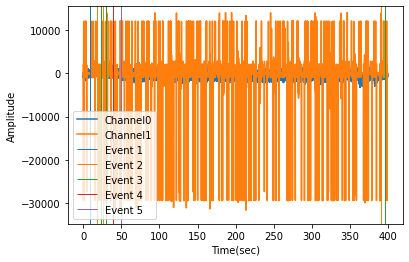

In [10]:
s1 = Session(r"C:\Users\USER\Documents\BYB\BYB_Recording_2021-06-18_16.14.32.wav", 'y')

s1.plot_overview(show_events=True,show_legends=True)


Normalizing

In [11]:
s1._normalize("scalar", 1/np.max(s1.get_channel(1).get_data()), 1)
#s1.plot_interval(1,1,10)
s1._normalize("scalar", 1/np.max(s1.get_channel(0).get_data()), 0)

1994884
Channel plotted
1994884
Channel plotted
Event plotted
Event plotted
Event plotted
Event plotted
Event plotted


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


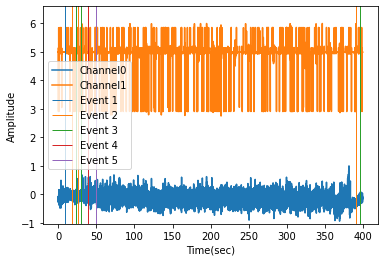

In [12]:
s1.plot_overview(offset=5, show_events=True,show_legends=True)

Filtering

1994884
Channel plotted
1994884
Channel plotted


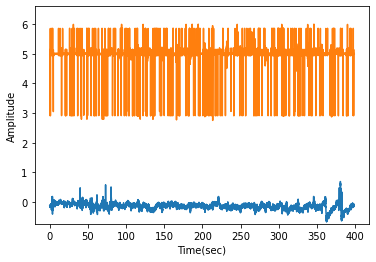

In [13]:
#s1._filt(cutoff=50, ftype = 'lp', filter_order = 2, channel_index = 0)
s1._filt(cutoff=30, ftype = 'lp', filter_order = 2, channel_index = 0)
s1.plot_overview(offset=5)

Plotting Interval

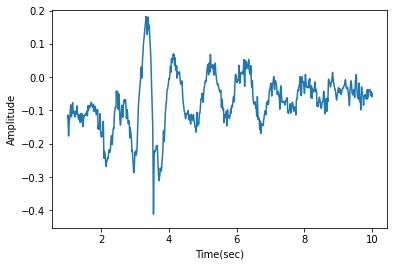

In [14]:
s1.plot_interval(0,1,10)

Power Spectral Density

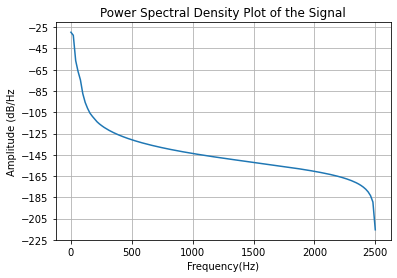

In [15]:
s1.psd(0,)

Spectrogram of Signal

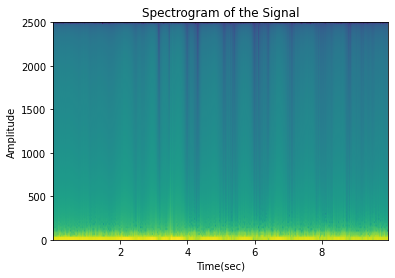

In [16]:
s1.spectrogram(0, 0, 10)